# Proyek Klasifikasi Gambar: English Premier League Logo Detection (20k Images)
- **Nama:** Muhammad Syarif Hidayat
- **Email:** mshidayat66@gmail.com
- **ID Dicoding:** mshidayat66

## Import Semua Packages/Library yang Digunakan

In [ ]:
!pip install -q kaggle
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
import os
import random
from random import sample
import shutil
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import io
import pathlib

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import load_model

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"msyarifhidayat","key":"1c8f7433900b5c279d9b12555cfd635d"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d 'alexteboul/english-premier-league-logo-detection-20k-images'
!unzip english-premier-league-logo-detection-20k-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: epl-logos-big/epl-logos-big/southampton/01bdf559-6db9-4054-be0b-a16dad708404.png  
  inflating: epl-logos-big/epl-logos-big/southampton/01d70ebc-aec8-4833-ab31-34c43b877e51.png  
  inflating: epl-logos-big/epl-logos-big/southampton/02162441-a35c-402e-b661-2442b96b58e6.png  
  inflating: epl-logos-big/epl-logos-big/southampton/02616ebe-6ecd-4e2b-8002-526b5d3eae22.png  
  inflating: epl-logos-big/epl-logos-big/southampton/02724a4f-573d-4b00-92d7-ea898f05c6a5.png  
  inflating: epl-logos-big/epl-logos-big/southampton/028c1975-4564-40d0-b5cd-f21f55e7ecd5.png  
  inflating: epl-logos-big/epl-logos-big/southampton/029a55ad-7461-4848-9d8e-af5b2d3f39b3.png  
  inflating: epl-logos-big/epl-logos-big/southampton/02bd1283-d900-4ee5-973a-ef3d6a02c471.png  
  inflating: epl-logos-big/epl-logos-big/southampton/0361f3bf-4693-480e-ae2f-c70346a87ec3.png  
  inflating: epl-logos-big/epl-logos-big/southampton/0371f512-7359-48cd-8a8f-31f14b4a

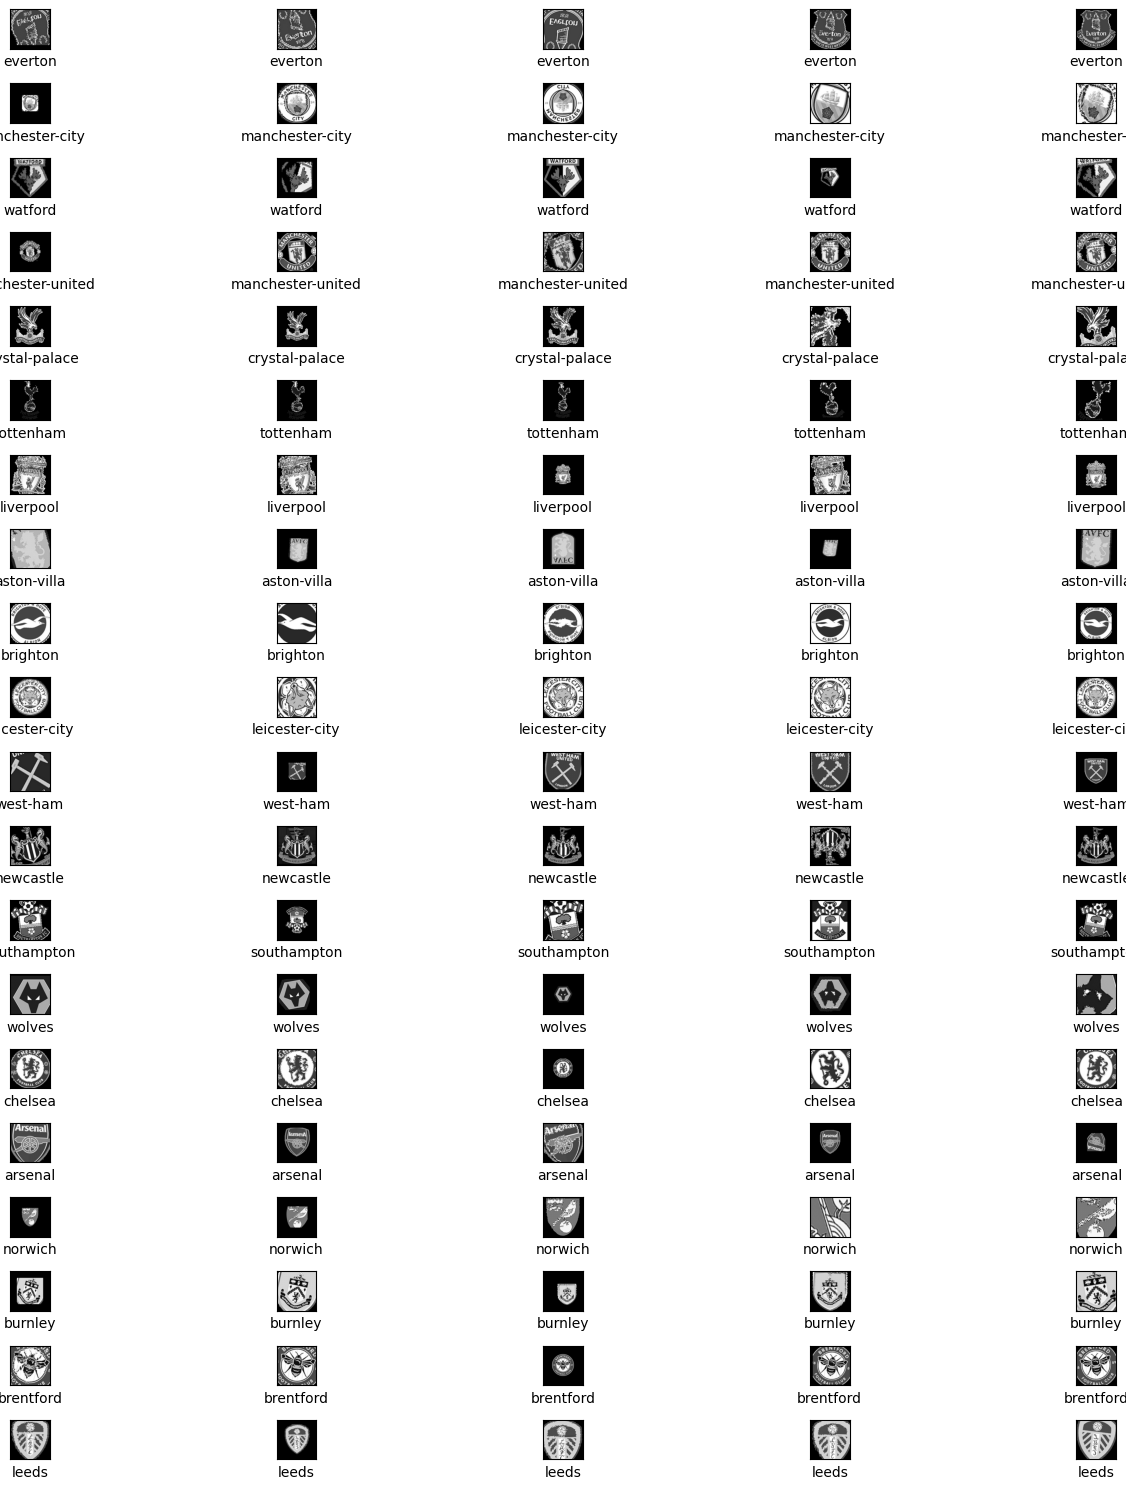

In [ ]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
logo = {}

# Tentukan path sumber
path = "epl-logos-big/"
path_sub = os.path.join(path, "epl-logos-big/")
for i in os.listdir(path_sub):
    logo[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah setiap dari 2 kelas dari data.
path_sub = "epl-logos-big/epl-logos-big/"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data
fig, axs = plt.subplots(len(logo.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(logo[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("L")  # Konversi menjadi skala keabuan
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

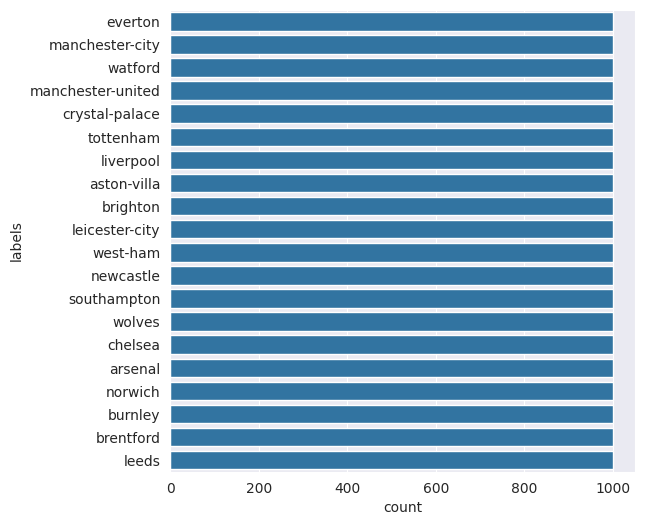

In [ ]:
# Definisikan path sumber
logo_path = "epl-logos-big/epl-logos-big"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(logo_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

### Data Preprocessing

#### Split Dataset

In [ ]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'epl-logos-big/epl-logos-big'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Memasukkan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapi
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
arsenal,1000
aston-villa,1000
brentford,1000
brighton,1000
burnley,1000
chelsea,1000
crystal-palace,1000
everton,1000
leeds,1000


In [ ]:
# Variabel yang digunakan pada pemisahan data ini di mana variabel x = data path dan y = data labels

X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
train_ratio = 0.60
validation_ratio = 0.20
test_ratio = 0.20

#Train 60%, Test 20%, Validation 20%
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1 - train_ratio, random_state=24)

X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio))

In [ ]:
# Menyatukan ke dalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})
df_va = pd.DataFrame({'path':X_val,'labels':y_val,'set':'val'})

In [ ]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te, df_va], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sampel data
print(df_all.sample(5))

# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "epl-logos-big/epl-logos-big"
# Membuat variabel Dataset, tempat menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"


set    labels           
test   arsenal              168
       aston-villa          211
       brentford            221
       brighton             189
       burnley              211
       chelsea              212
       crystal-palace       197
       everton              206
       leeds                215
       leicester-city       205
       liverpool            196
       manchester-city      195
       manchester-united    198
       newcastle            209
       norwich              188
       southampton          197
       tottenham            179
       watford              192
       west-ham             190
       wolves               221
train  arsenal              614
       aston-villa          587
       brentford            595
       brighton             608
       burnley              599
       chelsea              592
       crystal-palace       592
       everton              586
       leeds                601
       leicester-city       599
       liverpo

In [ ]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [ ]:
# Definisikan direktori training dan test
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"
VAL_DIR = "Dataset-Final/val/"

In [ ]:
# Buat objek ImageDataGenerator yang menormalkan gambar
datagen = ImageDataGenerator(rescale=1./255,
                             vertical_flip=True,
                             shear_range = 0.2,
                             fill_mode = 'nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              color_mode="grayscale",
                                              class_mode='categorical',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(VAL_DIR,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                   color_mode="grayscale",
                                                   class_mode='categorical',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150,150),
                                                  color_mode="grayscale",
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 12000 images belonging to 20 classes.
Found 4000 images belonging to 20 classes.
Found 4000 images belonging to 20 classes.


## Modelling

In [ ]:
model_1 = Sequential()

model_1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150,150,1)))
model_1.add(MaxPool2D((2, 2)))
model_1.add(Conv2D(32, (4, 4), activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))
model_1.add(Dropout(0.2))
model_1.add(Flatten())
model_1.add(Dropout(0.5))
model_1.add(Dense(32, activation = 'relu'))
model_1.add(Dense(20, activation='softmax'))

model_1.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Summary of the Model Architecture
print(model_1.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 71, 71, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 71, 71, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 35, 35, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 35, 35, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 39200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 39200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     1,254,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           660 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,271,956 (4.85 MB)

 Trainable params: 1,271,892 (4.85 MB)

 Non-trainable params: 64 (256.00 B)

None


In [ ]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        train_acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')

        if train_acc and val_acc:
            if train_acc > 0.95 and val_acc > 0.95 and epoch > 3:
                print(f"\nAkurasi Training: {train_acc*100:.2f}%, Akurasi Validasi: {val_acc*100:.2f}%")
                print("Kedua akurasi > 95%. Training dihentikan.")
                self.model.stop_training = True

callbacks = MyCallback()

# Fitting / training model
history_1 = model_1.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=validation_generator,
                        callbacks=[callbacks])

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


375/375 ━━━━━━━━━━━━━━━━━━━━ 53s 124ms/step - accuracy: 0.6133 - loss: 1.5020 - val_accuracy: 0.7197 - val_loss: 0.9303
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 44s 117ms/step - accuracy: 0.9691 - loss: 0.1075 - val_accuracy: 0.9768 - val_loss: 0.1012
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 43s 114ms/step - accuracy: 0.9812 - loss: 0.0645 - val_accuracy: 0.9790 - val_loss: 0.0949
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 43s 116ms/step - accuracy: 0.9867 - loss: 0.0457 - val_accuracy: 0.9620 - val_loss: 0.2117
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 43s 114ms/step - accuracy: 0.9880 - loss: 0.0524 - val_accuracy: 0.7937 - val_loss: 1.0518
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 44s 117ms/step - accuracy: 0.9845 - loss: 0.0504 - val_accuracy: 0.9120 - val_loss: 0.4407
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9913 - loss: 0.0326
Akurasi Training: 98.91%, Akurasi Validasi: 98.40%
Kedua akurasi > 95%. Training dihentikan.
375/375 ━━━━━━━━━━━━━━━━━━━━ 43s 114ms/step -

## Evaluasi dan Visualisasi

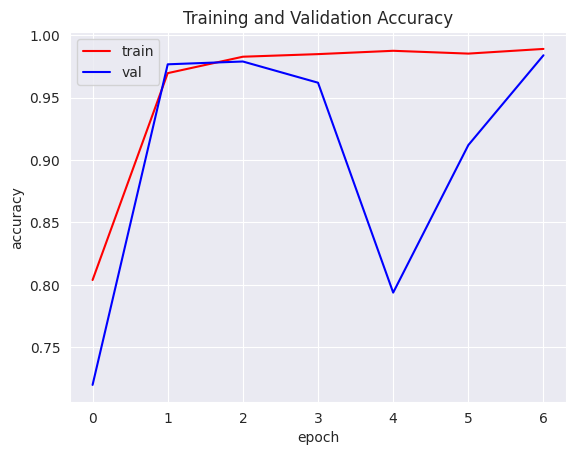

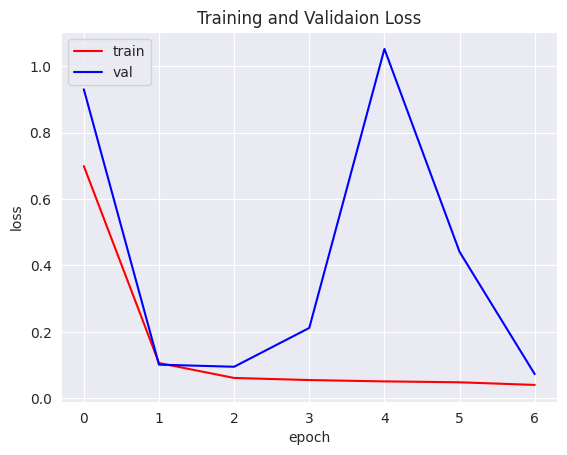

In [ ]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

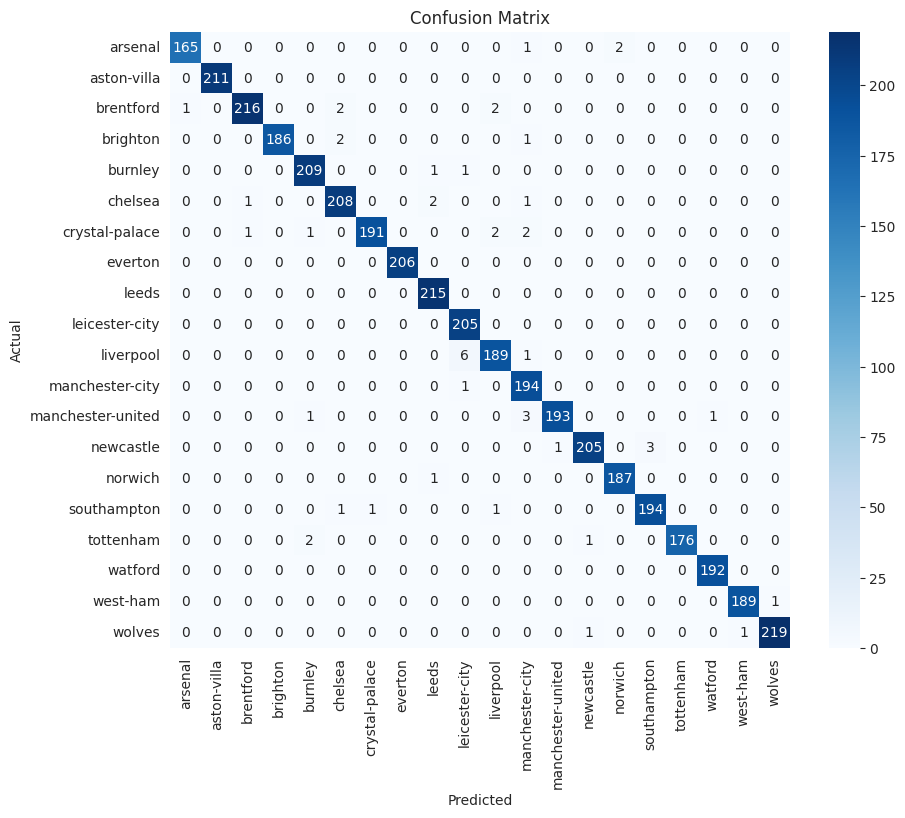


Classification Report:

                   precision    recall  f1-score   support

          arsenal     0.9940    0.9821    0.9880       168
      aston-villa     1.0000    1.0000    1.0000       211
        brentford     0.9908    0.9774    0.9841       221
         brighton     1.0000    0.9841    0.9920       189
          burnley     0.9812    0.9905    0.9858       211
          chelsea     0.9765    0.9811    0.9788       212
   crystal-palace     0.9948    0.9695    0.9820       197
          everton     1.0000    1.0000    1.0000       206
            leeds     0.9817    1.0000    0.9908       215
   leicester-city     0.9624    1.0000    0.9809       205
        liverpool     0.9742    0.9643    0.9692       196
  manchester-city     0.9557    0.9949    0.9749       195
manchester-united     0.9948    0.9747    0.9847       198
        newcastle     0.9903    0.9809    0.9856       209
          norwich     0.9894    0.9947    0.9920       188
      southampton     0.9848  

In [ ]:
test_generator.reset()

preds_1 = model_1.predict(test_generator,verbose=0)
preds_1 = preds_1.copy()
preds_1 = np.argmax(preds_1, axis=1)

# Print Confusion Matrix
class_names = test_generator.class_indices.keys()
cm = confusion_matrix(test_generator.classes, preds_1)

plt.figure(figsize=(10,8))
sns.heatmap(pd.DataFrame(cm, index=class_names, columns=class_names), annot=True, fmt="d", cmap="Blues")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report
print("\nClassification Report:\n")
print(classification_report(test_generator.classes, preds_1, target_names=class_names, digits=4))

## Konversi Model

In [ ]:
# Saved Model
save_path = 'saved_model/'
tf.saved_model.save(model_1, save_path)

In [ ]:
# Membuat file label.txt
label = list(train_generator.class_indices.keys())

with open("label.txt", "w") as f:
    for label in labels:
        f.write(f"{label}\n")


# Convert SavedModel menjadi model.tflite
model = "saved_model"
converter = tf.lite.TFLiteConverter.from_saved_model(save_path)
tflite_model = converter.convert()

# Simpan sebagai model.tflite
tflite_model_file = pathlib.Path("model.tflite")
tflite_model_file.write_bytes(tflite_model)

8832

In [ ]:
# Convert SavedModel to tfjs
!tensorflowjs_converter --input_format=tf_saved_model saved_model tfjs_model

2025-04-11 14:03:50.822786: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744380230.842961    2956 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744380230.850182    2956 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-04-11 14:03:56.042158: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1744380236.042321    2956 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

## Inference (Optional)

Saving png-transparent-premier-league-logo-brighton-hove-albion-fc-pro-evolution-soccer-2018-brighton-and-hove-pro-evolution-soccer-2017-emblem-organization-england-thumbnail.png to png-transparent-premier-league-logo-brighton-hove-albion-fc-pro-evolution-soccer-2018-brighton-and-hove-pro-evolution-soccer-2017-emblem-organization-england-thumbnail.png


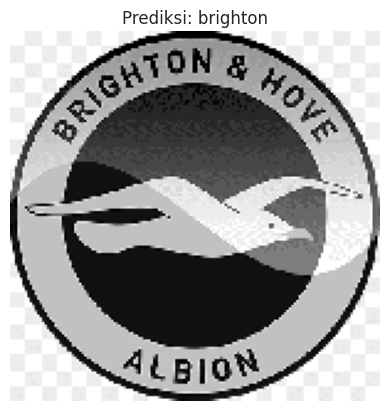

In [ ]:
from google.colab import files
uploaded = files.upload()

# Load model yang telah disimpan
saved_model = "saved_model"
model = keras.layers.TFSMLayer(saved_model, call_endpoint='serving_default')

# Ambil nama file yang diupload
filename = list(uploaded.keys())[0]

# Load dan resize gambar
img = image.load_img(io.BytesIO(uploaded[filename]), target_size=(150, 150), color_mode='grayscale')

# Ubah ke array
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # tambahkan batch dimensi
img_array /= 255.0  # normalisasi

# Convert ke Tensor
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)

# Prediksi
output = model(img_tensor)
if isinstance(output, dict):
    output = list(output.values())[0]

predicted_class = tf.argmax(output, axis=1).numpy()[0]

# Mapping label langsung dari train_generator
label_map = train_generator.class_indices
inv_label_map = {v: k for k, v in label_map.items()}

# Tampilkan hasil
plt.imshow(img, cmap='gray')
plt.title(f"Prediksi: {inv_label_map[predicted_class]}")
plt.axis('off')
plt.show()

In [ ]:
!pip freeze > requirements.txt